In [1]:
import numpy as np
import pandas as pd
# Some configurations to "beautify" plots
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["font.family"] = "Libre Franklin"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "white"

# Reducing the dimensionality of the metrics

First, let's load the ABIDE dataset, and apply the site-wise normalization.

In [2]:
from mriqc_learn.viz import metrics
from mriqc_learn.models.preprocess import SiteRobustScaler
from mriqc_learn.datasets import load_dataset

(train_x, train_y), _ = load_dataset(split_strategy="none")
train_x.drop(columns=["size_x", "size_y", "size_z", "spacing_x", "spacing_y", "spacing_z"])
numeric_columns = train_x.columns.tolist()
train_x["site"] = train_y.site

# Harmonize between sites
scaled_x = SiteRobustScaler(unit_variance=True).fit_transform(train_x)

We have a total of 62 features (i.e., metrics), and many of them are related (e.g., region-wise SNR calculations, or different ways of estimating a particular measure).
Highly correlated (either positive or negatively correlated) are not adding much information about the image to one another.
We therefore expect to see high (negative and positive) correlations between different metrics:

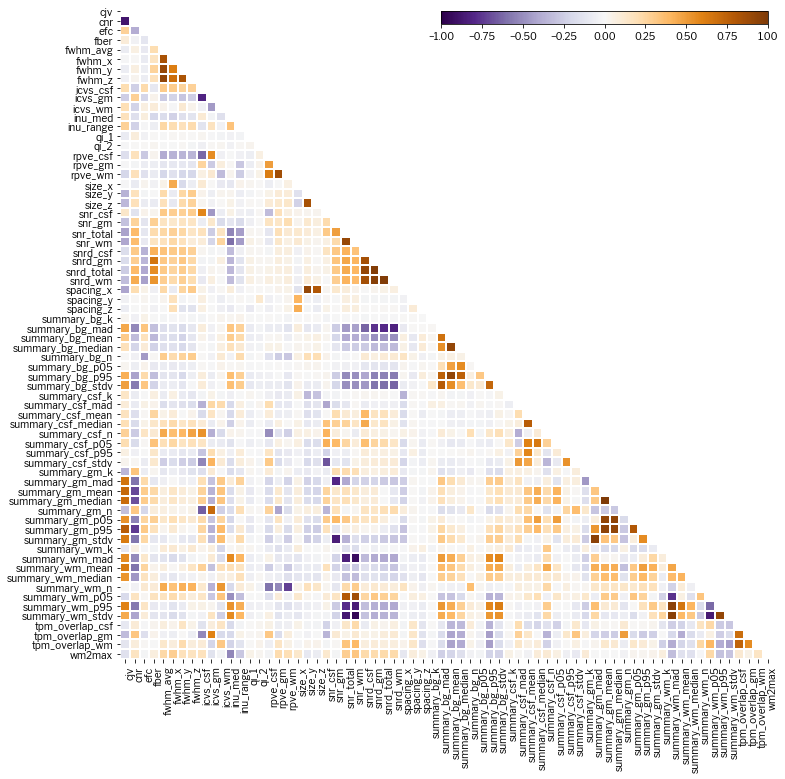

In [3]:
metrics.plot_corrmat(scaled_x[numeric_columns].corr(), figsize=(12, 12));

## Principal Components Analysis (PCA)

PCA is a fundamental statistical decomposition of data that was proposed to resolve the problem of source separation.
By using a few of the largest components, the signal can effectively be reduced from our initial 62 channels into a much lower number.
We will be using scikit-learn and scipy in this example:

In [4]:
from scipy import stats
from sklearn.decomposition import PCA

First we instantiate the model without limiting the number of components and fit the model to the numeric columns (i.e., without site of origin) of our dataframe:

In [5]:
pca_model = PCA(n_components=None).fit(scaled_x[numeric_columns])

Now let's investigate this PCA model.
To make an educated guess of a sufficient number of components for properly representing the data, we typically look at an elbow plot showing the variance explained vs. the number of components.

In [6]:
fig = plt.figure(figsize=(15,6))
ax = plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100), "-x")
plt.ylabel("Cumulative variance explained [%]")
plt.xlabel("Number of components")
xticks = np.arange(0, pca.explained_variance_ratio_.size, dtype=int)
plt.xticks(xticks)
plt.gca().set_xticklabels(xticks + 1)
plt.show()

NameError: name 'pca' is not defined

<Figure size 1080x432 with 0 Axes>

We can see that the first four components account for 99% of the variance, which is pretty high.
Let's then choose to keep four components from now on:

In [ ]:
n_components = 4

Components are no more than linear decomposition of the original metrics, so let's now look at the coefficients that correspond to the IQMs for each of those first four components:

In [ ]:
basis = pca_model.components_[:n_components,:]
fig, axs = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(24, 6))
for k in range(basis.shape[0]):
    axs[k].plot(np.abs(basis[k,:]), "x")
    axs[k].set_title(f"Component {k + 1}")

The first two components are basically aligned with one original metric each.
The second two are more composite of several metrics, but again only two features weight above 0.5, in both cases.

Let's refit the model with the limitation of 4 components, and project our original data onto the new four-dimensional space.

In [ ]:
iqm_reduced = PCA(n_components=n_components).fit_transform(
  scaled_x[numeric_columns]
)
components = pd.DataFrame(iqm_reduced, columns=[f"PC{i}" for i in range(1, n_components + 1)])
components["site"] = scaled_x["site"].values
components

The components should not be correlated:

In [ ]:
components.drop(columns=["site"])
metrics.plot_corrmat(components.corr(), figsize=(12, 12));